In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import _pickle as cPickle
import gzip
import functools
import dask
from dask import compute, delayed
from itertools import chain
from collections import OrderedDict

warnings.filterwarnings('ignore')

HEAD_PATH = '/Users/sean/Desktop/Plan B/Quant'
DATA_PATH = HEAD_PATH + '/energy pkl tick/'

import os
os.chdir(DATA_PATH)

import multiprocessing
print(multiprocessing.cpu_count())
print(os.cpu_count())

CORE_NUM = int(multiprocessing.cpu_count())

print(os.getcwd())

# Product list
product_list = ['bu', 'ru', 'v', 'pp', 'l', 'jd']
product = product_list[0]

dire = DATA_PATH + product
print(dire)

# sort dates
all_dates = list(map(lambda x: x, os.listdir(dire)))
dates = []
for i in range(len(all_dates)):
    dates.append(int(all_dates[i][0:8]))
dates = np.sort(dates)
all_dates = []
for i in dates:
    all_dates.append(str(i) + '.pkl')
    
print(len(all_dates))
print(all_dates[0:6])

12
12
/Users/sean/Desktop/Plan B/Quant/energy pkl tick
/Users/sean/Desktop/Plan B/Quant/energy pkl tick/bu
1088
['20160601.pkl', '20160602.pkl', '20160603.pkl', '20160606.pkl', '20160607.pkl', '20160608.pkl']


In [2]:
date = '20180611'

with gzip.open(dire + '/' + date + '.pkl', 'rb', compresslevel=1) as file_object:
    raw_data = file_object.read()
data = cPickle.loads(raw_data)

In [3]:
data.columns

Index(['contract', 'date.time', 'price', 'cum.open.int', 'open.int',
       'turnover', 'qty', 'bid', 'ask', 'bid.qty', 'ask.qty', 'date', 'time',
       'milli', 'good', 'mid.price', 'buy.trade', 'buy2.trade', 'sell.trade',
       'sell2.trade', 'log.price', 'ret', 'wpr', 'wpr.ret', 'next.ask',
       'next.bid', 'min.1024', 'max.1024', 'min.2048', 'max.2048', 'min.4096',
       'max.4096'],
      dtype='object')

|  NAME   |          EXPLANATION                   | 
| ------:  |   :-----------------------------------  |
|Contract | contract name, product+expiration date |
|date.time|            date and time               |
| price   |         newest price of data         |
|cum.open.int| cumulative open interest|
|open.int| newest open interest increment|
| turnover| newest turnover increment|
| qty | newest trading volume|
| bid | bid price|
| ask| ask price|
|bid.qty| bid size|
| ask.qty| ask size|
| date | actual date|
| time | acutal time|
| milli | actual milli second|
| mid.price | middle price of bid and ask|
| buy.trade | active buy volume at level 1|
| buy2.trade | active buy volume at other levels|
| sell.trade | active sell volume at level 1|
| sell2.trade | active sell volume at other levels|
| log.price | log wpr (to be defined soon)|
| ret | log return of last tick|
| wpr | volume weighted price|
| wpr.ret | price change of wpr|
| high | highest price of last ask, last price, and this ask|
| low | lowest price of last bid, last price, and thsi bid|
| next.bid |  estimated active sell price, used for backtesting|
| next.ask | estimated active buy price, used for backtesting|
| min.1024 | rolling minimum of wpr over 1024 ticks|
| max.1024 | rolling maximum of wpr over 1024 ticks|
| min.2048 | rolling minimum of wpr over 2048 ticks |
|max.2048  |rolling maximum of wpr over 2048 ticks|
| min.4096 | rolling minimum of wpr over 4096 ticks|
| max.4096 | rolling maximum of wpr over 4096 ticks|

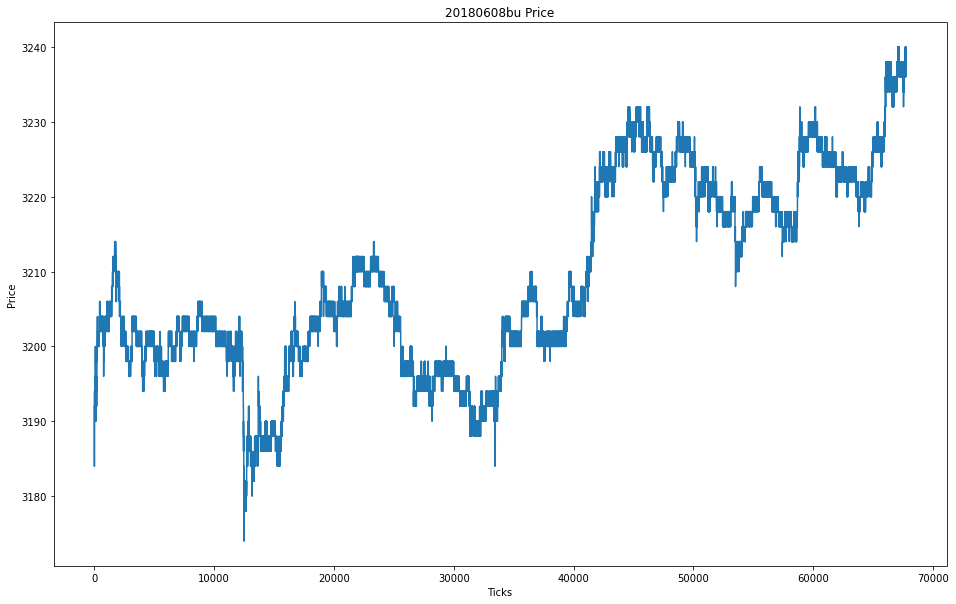

In [9]:
plt.figure(1, figsize=(16, 10))
plt.plot(data["price"].values)
plt.title('20180608bu Price')
plt.xlabel('Ticks')
plt.ylabel('Price');

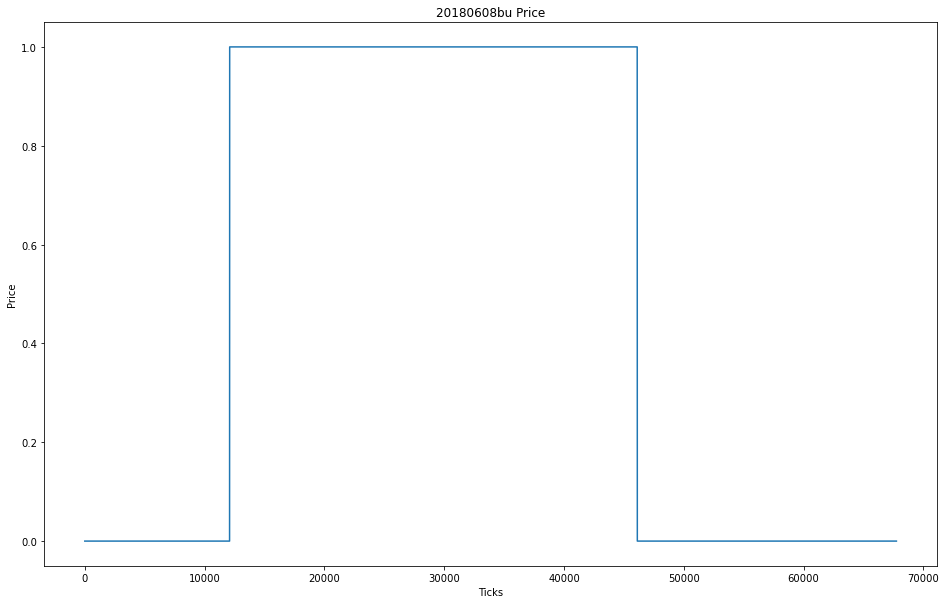

In [10]:
# 前面good=False的数据用来计算因子预热
# 第三天的good=False用来计算因变量，比如未来的收益率，因此需要后面一天；
# 中间good=True才是真正用来回测的

plt.figure(1, figsize=(16, 10))
plt.plot(data["good"].values)
plt.title('20180608bu Price')
plt.xlabel('Ticks')
plt.ylabel('Price');

In [11]:
data['time']

0        20:59:00
1        21:00:00
2        21:00:01
3        21:00:01
4        21:00:02
           ...   
67741    14:59:58
67742    14:59:59
67743    14:59:59
67744    15:00:00
67745    15:00:00
Name: time, Length: 67746, dtype: object

34024
34024


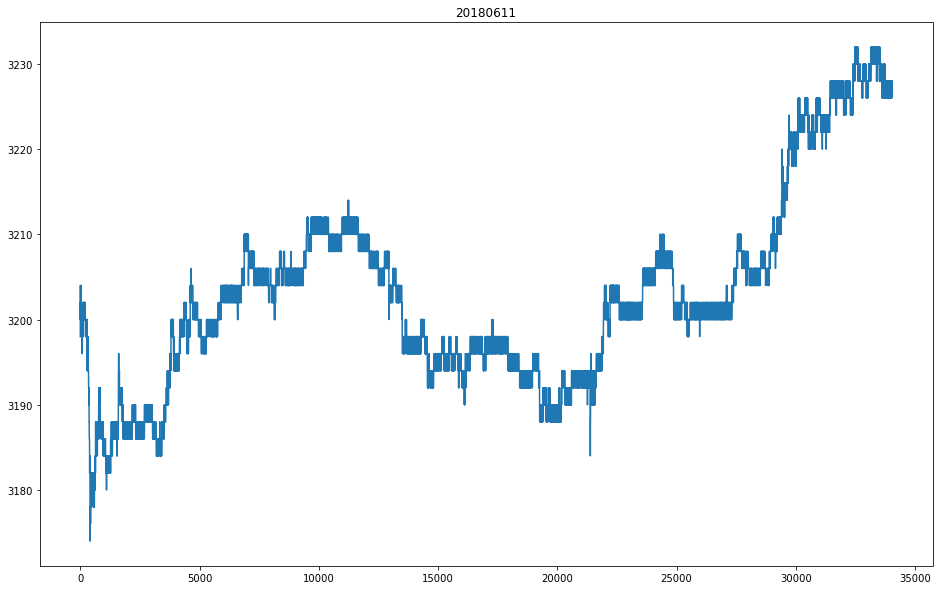

In [13]:
range_ = data['good']
print(len(data['price'][range_]))
print(len(data['price'][data['good']]))
plt.figure(1, figsize=(16,10))
plt.title(date)
plt.plot(data['price'][range_].values);

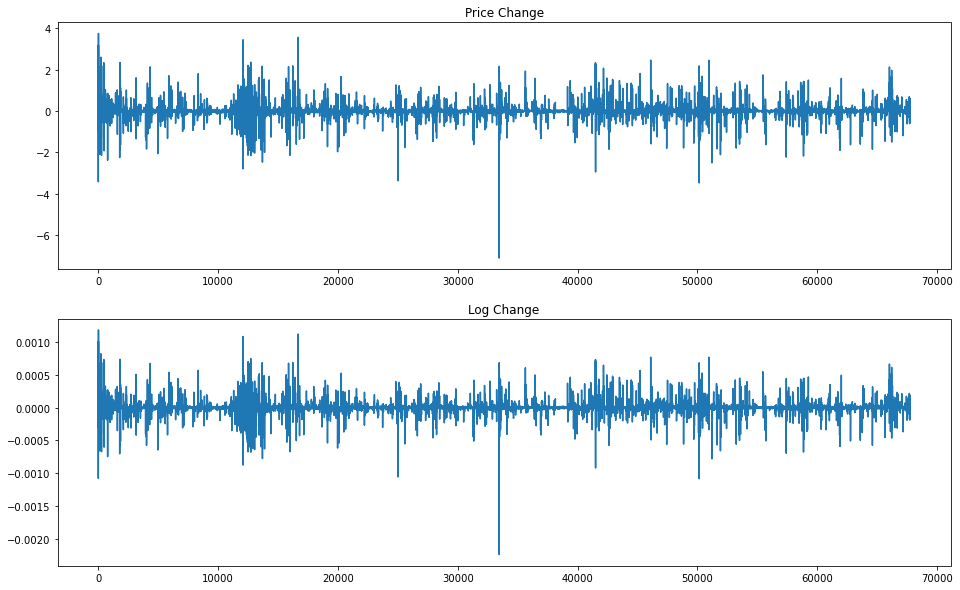

In [14]:
# price change and log return
data['wpr.ret'].values[0] = 0
figure = plt.figure(figsize=(16,10))
plt.subplot(2,1,1)
plt.plot(data['wpr.ret'].values)
plt.title("Price Change")
plt.subplot(2,1,2)
plt.plot(data['ret'].values)
plt.title('Log Change');

In [15]:
# rise, fall, even
print("Rise Freq: ",sum(data['ret'] > 0)/len(data))
print("Fall Freq: ",sum(data['ret'] < 0)/len(data))
print("Even Freq: ",sum(data['ret'] == 0)/len(data))

Rise Freq:  0.4036695893484486
Fall Freq:  0.3998464854013521
Even Freq:  0.19648392525019928


In [16]:
# volumn weighted price 
wpr = (data["bid"]*data["ask.qty"]+data["ask"]*data["bid.qty"])/(data["bid.qty"]+data["ask.qty"])

In [17]:
# 检查是否有涨停或跌停
limit = (data["ask.qty"]==0) | (data["bid.qty"]==0)
def limit_or_not(ask, bid, data, price):
    limit = (data[ask]==0) | (data[bid]==0)
    if len(price[limit]) == 0:
        print("No Limit Happen")
    else:
        print("Limit Happen")
        Down_limit_tick = np.where(price['ask']==0)
        Up_limit_tick = np.where(price['bid']==0)
limit_or_not("ask.qty", "bid.qty", data, data['wpr'])

No Limit Happen


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
No handles with labels found to put in legend.


Test Statistic:  -30.416742119989692
P Value:  0.0
Num of Lags:  32
Num of Obv:  33991
1% Stat:  -3.959036362756469
5% Stat:  -3.410619171424034
10% Stat:  -3.127126070591954
-------------------------------------------------
Test Statistic:  0.19378023107312264
P Value:  0.1
Num of Lags:  42
1% Stat:  0.739
5% Stat:  0.463
10% Stat:  0.347
Test Statistic:  -6.3156550343260776
P Value:  4.6573373596620135e-07
Num of Lags:  6
Num of Obv:  277
1% Stat:  -3.991829482256766
5% Stat:  -3.426459719467921
10% Stat:  -3.136436503072161
-------------------------------------------------
Test Statistic:  0.17423239862810222
P Value:  0.1
Num of Lags:  3
1% Stat:  0.739
5% Stat:  0.463
10% Stat:  0.347


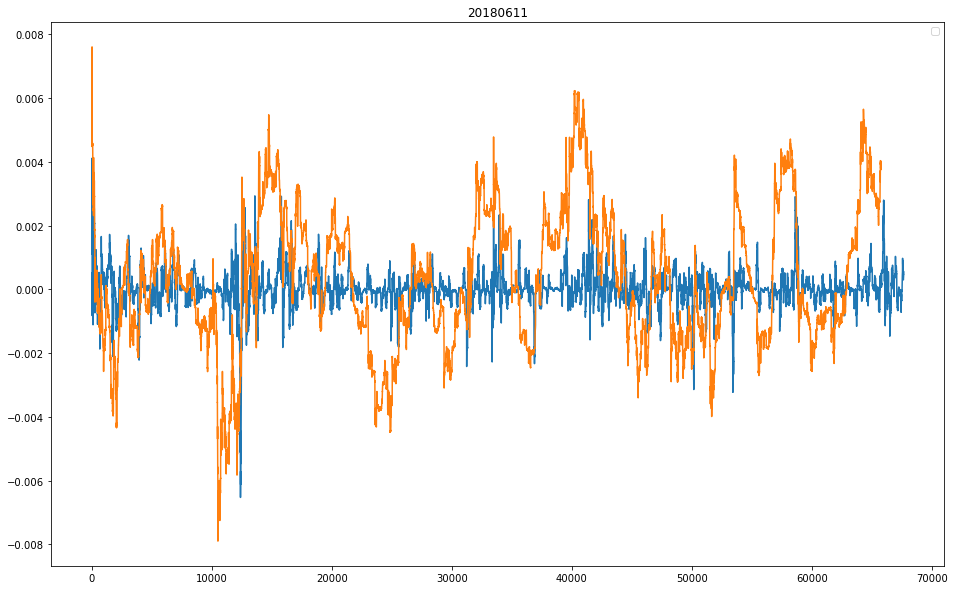

In [18]:
import statsmodels.tsa.stattools as ts

result = ts.adfuller(data["ret"][data["good"]], maxlag=int(pow(len(data["ret"][data["good"]])-1,(1/3))), regression='ct', autolag=None)
print("Test Statistic: ", result[0])
print("P Value: ", result[1])
print("Num of Lags: ", result[2])
print("Num of Obv: ", result[3])
print("1% Stat: ", result[4]['1%'])
print("5% Stat: ", result[4]['5%'])
print("10% Stat: ", result[4]['10%'])
print("-------------------------------------------------")

result = ts.kpss(data["ret"][data["good"]], regression='c', lags=int(3*math.sqrt(len(data["ret"][data["good"]]))/13))
print("Test Statistic: ", result[0])
print("P Value: ", result[1])
print("Num of Lags: ", result[2])
print("1% Stat: ", result[3]['1%'])
print("5% Stat: ", result[3]['5%'])
print("10% Stat: ", result[3]['10%'])
print("=================================================")

range_120 = ((np.mod(np.arange(0, len(data)),120)==0) & data["good"])[119:]
ret_120 = (data["ret"].rolling(120).sum()).dropna().reset_index(drop=True)
result = ts.adfuller(ret_120.iloc[np.where(range_120)], maxlag=int(pow(len(ret_120.iloc[np.where(range_120)])-1,(1/3))), regression='ct', autolag=None)
print("Test Statistic: ", result[0])
print("P Value: ", result[1])
print("Num of Lags: ", result[2])
print("Num of Obv: ", result[3])
print("1% Stat: ", result[4]['1%'])
print("5% Stat: ", result[4]['5%'])
print("10% Stat: ", result[4]['10%'])
print("-------------------------------------------------")


result = ts.kpss(ret_120.iloc[np.where(range_120)], regression='c', lags=int(3*math.sqrt(len(ret_120.iloc[np.where(range_120)]))/13))
print("Test Statistic: ", result[0])
print("P Value: ", result[1])
print("Num of Lags: ", result[2])
print("1% Stat: ", result[3]['1%'])
print("5% Stat: ", result[3]['5%'])
print("10% Stat: ", result[3]['10%'])
print("=================================================")

ret_2000 = (data["ret"].rolling(2000).sum()).dropna().reset_index(drop=True)
plt.figure(1, figsize=(16, 10))
plt.title(date)
plt.plot(ret_120.values)
plt.plot(ret_2000.values)
plt.legend();

In [20]:
def load(path):
    with gzip.open(path, 'rb', compresslevel=1) as file_object:
        raw_data = file_object.read()
    return cPickle.loads(raw_data)

def get_sample_ret(date, period):
    data = load(DATA_PATH + product + '/' + date)
    ret = (data['ret'].rolling(period).sum()).dropna().reset_index(drop=True)
    range_ = ((np.mod(np.arange(0, len(data)), period)==0) & data['good'])[(period-1):]
    return ret.iloc[np.where(range_)]

def parLapply(CORE_NUM, iterable, func, *args, **kwargs):
    with dask.config.set(schedular='processes', num_workers=CORE_NUM):
        f_par = functools.partial(func, *args, **kwargs)
        result = compute([delayed(f_par)(item) for item in iterable])[0]
    return result

In [21]:
%%time
result = parLapply(CORE_NUM, all_dates, get_sample_ret, period=4096)
;

CPU times: user 2min 21s, sys: 1min 7s, total: 3min 28s
Wall time: 1min 45s


''

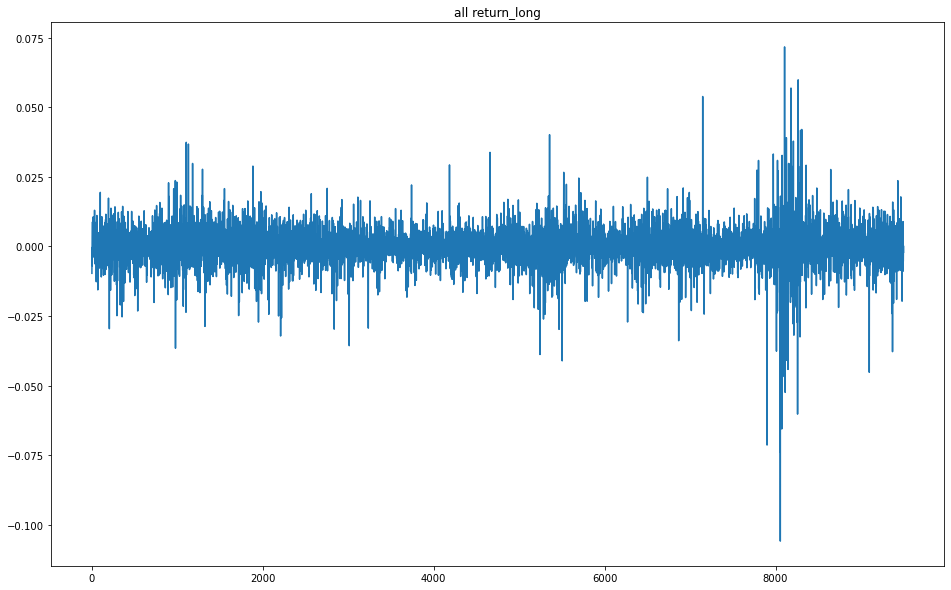

In [22]:
ret_long = list(chain.from_iterable(result))
plt.figure(1, figsize=(16, 10))
plt.title("all return_long")
plt.plot(ret_long);

In [23]:
result = ts.adfuller(ret_long, maxlag=int(pow(len(ret_long)-1,(1/3))), regression='ct', autolag=None)
print("Test Statistic: ", result[0])
print("P Value: ", result[1])
print("Num of Lags: ", result[2])
print("Num of Obv: ", result[3])
print("1% Stat: ", result[4]['1%'])
print("5% Stat: ", result[4]['5%'])
print("10% Stat: ", result[4]['10%'])
print("-------------------------------------")

result = ts.kpss(ret_long, regression='c', lags=int(3*math.sqrt(len(ret_long))/13))
print("Test Statistic: ", result[0])
print("P Value: ", result[1])
print("Num of Lags: ", result[2])
print("1% Stat: ", result[3]['1%'])
print("5% Stat: ", result[3]['5%'])
print("10% Stat: ", result[3]['10%'])
print("=====================================")


Test Statistic:  -20.688823758507763
P Value:  0.0
Num of Lags:  21
Num of Obv:  9476
1% Stat:  -3.959725688211695
5% Stat:  -3.4109534185386465
10% Stat:  -3.127322901483067
-------------------------------------
Test Statistic:  0.11474097481102562
P Value:  0.1
Num of Lags:  22
1% Stat:  0.739
5% Stat:  0.463
10% Stat:  0.347


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [25]:
threshold = 0.001
print(sum(np.array(ret_long)>threshold))
print(sum(np.array(ret_long)<-threshold))
print(sum(np.array(ret_long)==threshold))

3763
3759
0


In [30]:
def get_daily_pnl_fast(date, product, period=4096, tranct_ratio=False, threshold=0.001, tranct=0.21, noise=0):
    
    with gzip.open(dire + '/' + date, 'rb', compresslevel=1) as file_object:
        raw_data = file_object.read()
    ori_data = cPickle.loads(raw_data) # 解压数据
    
    data = ori_data[ori_data['good']] # 中间部分的数据用来回测
    
    n_bar = len(data)
    unit = np.std(data['ret'])
    np.random.seed(10)
    
    ## 计算每日收益率
    ret_period = (data['ret'].rolling(period).sum()).dropna().reset_index(drop=True) # 未来收益率，用来当作交易信号
    ret_period = ret_period.append(pd.Series([0] * (len(data) - len(ret_period)))).reset_index(drop=True)
    
    signal = pd.Series([0] * n_bar)
    signal[(ret_period > threshold) & (np.array(data['next.ask']) > 0)] = 1
    signal[(ret_period < -threshold) & (np.array(data['next.bid']) > 0)] = -1
    
    position = signal
    position[0] = 0
    position[n_bar-1] = 0
    position[n_bar-2] = 0
    change_of_position = position - position.shift(1)
    change_of_position[0] = 0
    change_base = np.zeros(n_bar)
    change_buy = np.array(change_of_position > 0)
    change_sell = np.array(change_of_position < 0)
    
    # 交易佣金
    if tranct_ratio:
        change_base[change_buy] = data['next.ask'][change_buy] * (1 + tranct) # 比率交易费用
        change_base[change_sell] = data['next.bid'][change_sell] * (1 - tranct)
    else:
        change_base[change_buy] = data['next.ask'][change_buy] + tranct # 固定交易费用
        change_base[change_sell] = data['next.bid'][change_sell] - tranct
    
    final_pnl = -sum(change_base * change_of_position) # pnl, 买 - ， 卖 +
    turnover = sum(change_base * abs(change_of_position)) 
    num = sum((position != 0) & (change_of_position != 0)) # 交易次数
    hld_period = sum(position != 0)
    
    result = OrderedDict([('date', date), ('final.pnl', final_pnl), ('turnover', turnover), ('num', num), ('hld.period', hld_period)])
    return result

# 一日盈亏
get_daily_pnl_fast(all_dates[0], product='bu', period=4096, tranct_ratio=True, threshold=0.001, tranct=1.1e-4)


OrderedDict([('date', '20160601.pkl'),
             ('final.pnl', -90.68950000001087),
             ('turnover', 224450.00726),
             ('num', 61),
             ('hld.period', 30254)])

In [31]:
%%time
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_daily_pnl_fast, product='bu', period=4096, tranct_ratio=True, threshold=0.001, tranct=1.1e-4, noise=0)
    result = compute([delayed(f_par)(date) for date in all_dates])[0]

CPU times: user 3.51 s, sys: 335 ms, total: 3.84 s
Wall time: 45.3 s


In [32]:
result[0:5]

[OrderedDict([('date', '20160601.pkl'),
              ('final.pnl', -90.68950000001087),
              ('turnover', 224450.00726),
              ('num', 61),
              ('hld.period', 30254)]),
 OrderedDict([('date', '20160602.pkl'),
              ('final.pnl', -187.95420000001968),
              ('turnover', 363220.01627999987),
              ('num', 98),
              ('hld.period', 18097)]),
 OrderedDict([('date', '20160603.pkl'),
              ('final.pnl', -106.24818000001528),
              ('turnover', 220438.0090200002),
              ('num', 59),
              ('hld.period', 24686)]),
 OrderedDict([('date', '20160606.pkl'),
              ('final.pnl', -87.72972000001664),
              ('turnover', 288452.0061600001),
              ('num', 76),
              ('hld.period', 28081)]),
 OrderedDict([('date', '20160607.pkl'),
              ('final.pnl', -75.75380000001155),
              ('turnover', 179580.00615999996),
              ('num', 47),
              ('hld.period', 2

In [33]:
def get_performance(result, spread=1):
    
    aa = pd.DataFrame(result)
    aa.set_index('date', inplace=True)
    col_names = aa.columns
    row_names = aa.index
    stat = aa.values
    stat = np.array(np.rec.fromrecords(aa.values))
    np_names = aa.dtypes.index.tolist()
    stat.dtype.names = tuple([name for name in np_names])
    stat = pd.DataFrame(stat)
    pnl = stat['final.pnl'].cumsum()
    
    date_str = [n[0:8] for n in row_names]
    date_format = [pd.to_datetime(d) for d in date_str]
    
    plt.figure(1, figsize=(16,10))
    plt.title("")
    plt.xlabel('Date')
    plt.ylabel('pnl')
    plt.plot(date_format, pnl)
    
    n_days = len(stat)
    num = stat['num'].mean()
    
    if num == 0:
        return;
    if (stat['final.pnl'].std()==0):
        sharpe = 0
    else:
        sharpe = stat['final.pnl'].mean()/stat['final.pnl'].std()*math.sqrt(250)
    
    drawdown = max(pnl.cummax() - pnl)/pnl.iloc[-1]
    mar = 1/drawdown
    win_ratio = sum(stat['final.pnl'] > 0)/n_days
    print('Win Ratio: ', win_ratio)
    
    avg_pnl = sum(stat['final.pnl'])/sum(stat['num'])/spread
    print('Average PnL: ', avg_pnl)
    
    hld_period = sum(stat['hld.period'])/sum(stat['num'])
    return OrderedDict([('sharpe', sharpe), ('drawdown', drawdown), ('mar', mar), ('win.ratio', win_ratio), ('num', num),
                        ('avg.pnl', avg_pnl), ('hld.period', hld_period)])

- threshold = 0.001

Win Ratio:  0.1056985294117647
Average PnL:  -1.8911064005928642


,sharpe,drawdown,mar,win.ratio,num,avg.pnl,hld.period
0,-2.325627,-1.07531,-0.929965,0.105699,84.378676,-1.891106,295.119951


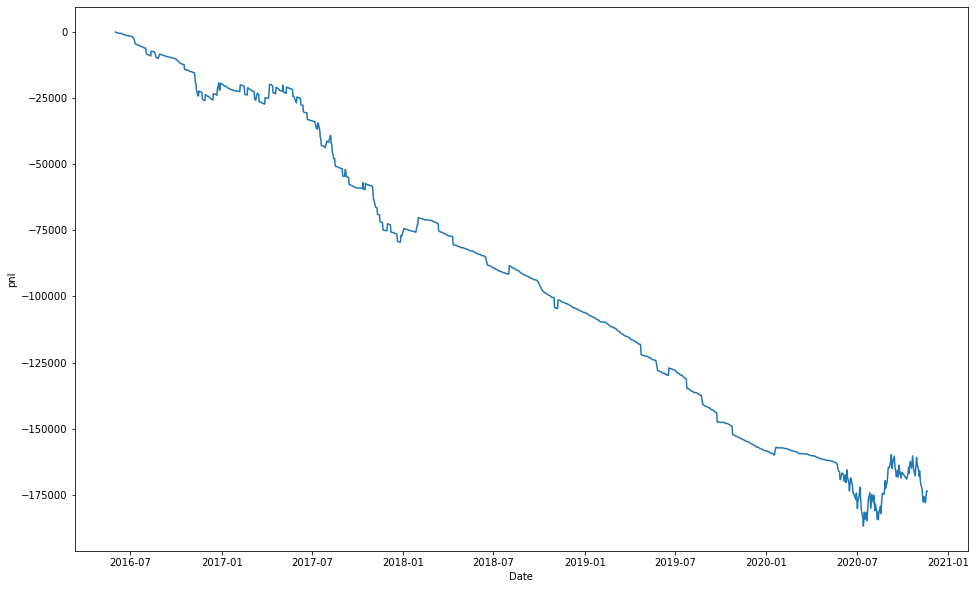

In [34]:
pd.DataFrame(get_performance(result, 1), index=[0])

- threshold = 0.01

Win Ratio:  0.1323529411764706
Average PnL:  -1.9897602335939744
CPU times: user 4.23 s, sys: 428 ms, total: 4.66 s
Wall time: 59.8 s


,sharpe,drawdown,mar,win.ratio,num,avg.pnl,hld.period
0,-0.901093,-1.092565,-0.915277,0.132353,12.590993,-1.98976,166.099277


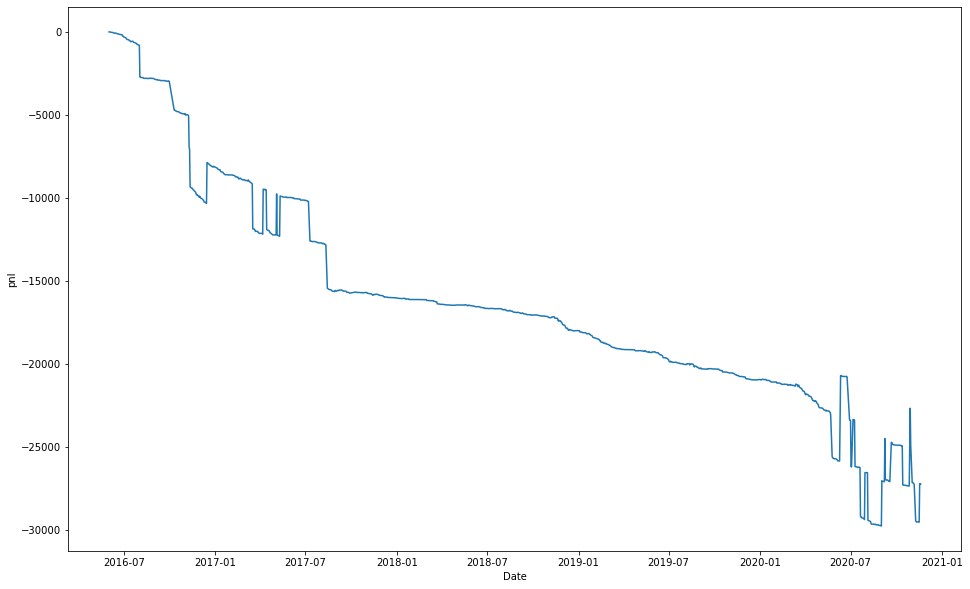

In [35]:
%%time
import functools
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_daily_pnl_fast, product="ru", period=4096, tranct_ratio=True, threshold=0.01, tranct=1.1e-4, noise=0)
    result_2 = compute([delayed(f_par)(date) for date in all_dates])[0]

pd.DataFrame(get_performance(result_2, 1), index=[0])

- threshold = 0.02

Win Ratio:  0.04136029411764706
Average PnL:  -0.5234954681142442
CPU times: user 3.76 s, sys: 377 ms, total: 4.13 s
Wall time: 35.7 s


,sharpe,drawdown,mar,win.ratio,num,avg.pnl,hld.period
0,-0.0999,-5.224588,-0.191403,0.04136,2.032169,-0.523495,125.024423


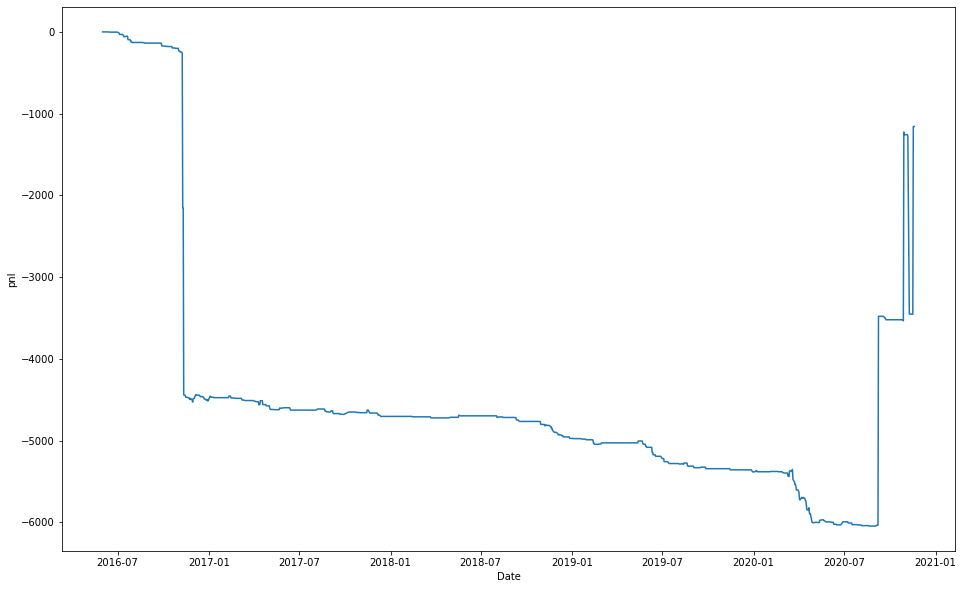

In [36]:
%%time
import functools
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_daily_pnl_fast, product="ru", period=4096, tranct_ratio=True, threshold=0.02, tranct=1.1e-4, noise=0)
    result_3 = compute([delayed(f_par)(date) for date in all_dates])[0]
    
pd.DataFrame(get_performance(result_3, 1), index=[0])

- threshold = 0.025

Win Ratio:  0.02389705882352941
Average PnL:  1.471543919413663
CPU times: user 3.94 s, sys: 346 ms, total: 4.28 s
Wall time: 34.9 s


,sharpe,drawdown,mar,win.ratio,num,avg.pnl,hld.period
0,0.18905,1.358326,0.7362,0.023897,1.003676,1.471544,103.708791


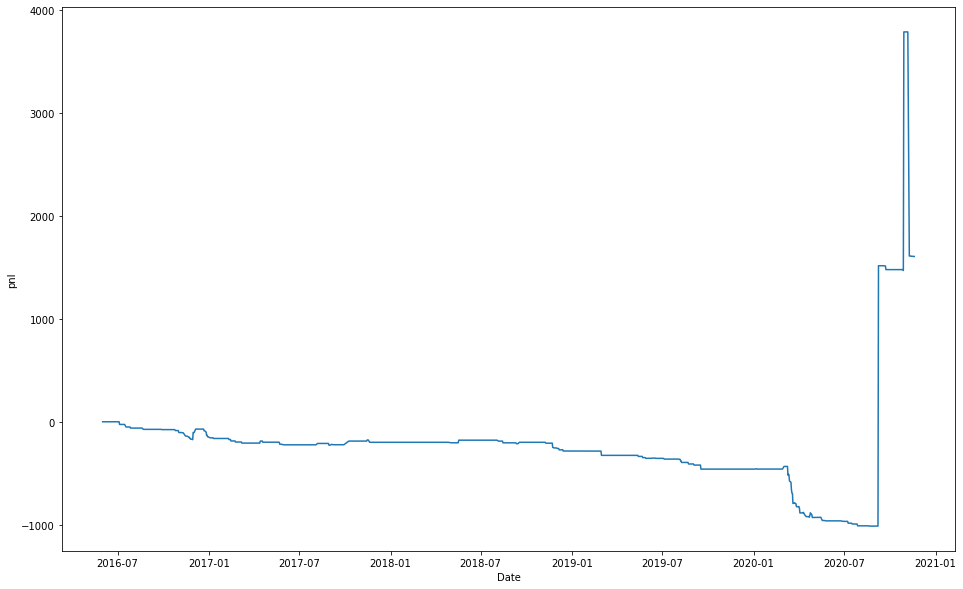

In [37]:
%%time
import functools
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_daily_pnl_fast, product="ru", period=4096, tranct_ratio=True, threshold=0.025, tranct=1.1e-4, noise=0)
    result_3 = compute([delayed(f_par)(date) for date in all_dates])[0]
    
pd.DataFrame(get_performance(result_3, 1), index=[0])

In [38]:
product_list = ['bu', 'ru', 'v', 'pp', 'l', 'jd']
product = product_list[3]

dire = DATA_PATH + product
print(dire)

/Users/sean/Desktop/Plan B/Quant/energy pkl tick/pp


In [39]:
dire = DATA_PATH + product
    
with gzip.open(dire + '/' + date + '.pkl', 'rb', compresslevel=1) as file_object:
    raw_data = file_object.read()
data = cPickle.loads(raw_data)
data

,contract,date.time,price,cum.open.int,open.int,turnover,qty,bid,ask,bid.qty,...,wpr,wpr.ret,next.ask,next.bid,min.1024,max.1024,min.2048,max.2048,min.4096,max.4096
0,pp1809,2018-06-08 08:59:00.020,9295.0,435990,76,14964950.0,322,9295.0,9296.0,1,...,9295.026316,5.026316,9296.0,9292.0,9295.026316,9295.026316,9295.026316,9295.026316,9295.026316,9295.026316
1,pp1809,2018-06-08 09:00:00.062,9295.0,435992,2,92950.0,2,9292.0,9296.0,10,...,9292.851064,-2.175252,9294.0,9293.0,9292.851064,9295.026316,9292.851064,9295.026316,9292.851064,9295.026316
2,pp1809,2018-06-08 09:00:00.567,9294.0,436502,510,31978120.0,688,9293.0,9294.0,6,...,9293.250000,0.398936,9296.0,9292.0,9292.851064,9295.026316,9292.851064,9295.026316,9292.851064,9295.026316
3,pp1809,2018-06-08 09:00:01.053,9295.0,436646,144,11430700.0,246,9292.0,9296.0,6,...,9294.181818,0.931818,9296.0,9293.0,9292.851064,9295.026316,9292.851064,9295.026316,9292.851064,9295.026316
4,pp1809,2018-06-08 09:00:01.556,9293.0,436664,18,5018950.0,108,9293.0,9296.0,1,...,9293.500000,-0.681818,9295.0,9292.0,9292.851064,9295.026316,9292.851064,9295.026316,9292.851064,9295.026316
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59323,pp1809,2018-06-12 14:59:58.201,9381.0,509042,34,3750250.0,80,9375.0,9377.0,83,...,9376.865169,-1.134831,9377.0,9375.0,9376.302632,9402.736842,9376.302632,9402.895833,9360.306452,9402.895833
59324,pp1809,2018-06-12 14:59:58.714,9375.0,509038,-4,562600.0,12,9375.0,9377.0,82,...,9376.975904,0.110735,9382.0,9374.0,9376.302632,9402.736842,9376.302632,9402.895833,9360.317460,9402.895833
59325,pp1809,2018-06-12 14:59:59.147,9381.0,509004,-34,1781630.0,38,9374.0,9382.0,10,...,9381.272727,4.296824,9380.0,9377.0,9376.302632,9402.736842,9376.302632,9402.895833,9360.328125,9402.895833
59326,pp1809,2018-06-12 14:59:59.681,9377.0,509002,-2,93770.0,2,9377.0,9380.0,3,...,9378.800000,-2.472727,9380.0,9377.0,9376.302632,9402.736842,9376.302632,9402.895833,9360.368764,9402.895833


In [45]:
def get_daily_pnl(date, product, period, tranct_ratio=False, threshold=0.001, tranct = 1.1e-4, noise=0):
    
    dire = DATA_PATH + product
    
    with gzip.open(dire + '/' + date, 'rb', compresslevel=1) as file_object:
        raw_data = file_object.read()
    data = cPickle.loads(raw_data)
    data = data[data['good']].reset_index(drop=True)

    n_bar = len(data)
    unit = np.std(data['ret'])
    np.random.seed(10)
    noise_ret = np.random.normal(scale=unit*noise, size=n_bar)
    
    ret_period = (data['ret'].rolling(period).sum()).dropna().reset_index(drop=True)
    ret_period = ret_period.append(pd.Series([0] * (len(data) - len(ret_period)))).reset_index(drop=True) + noise_ret

    signal = pd.Series([0] * n_bar)
    signal[ret_period > threshold] = 1
    signal[ret_period < -threshold] = -1

    position_positive = pd.Series([np.nan] * n_bar)
    position_positive[0] = 0
    position_positive[(signal==1) & (data['next.ask']>0) & (data['next.bid']>0)] = 1 # if signal = 1, then position_positive = 1
    position_positive[(ret_period < -threshold) & (data['next.bid'] > 0)] = 0 # if ret < -threshold, position_positive = 0
    position_positive.ffill(inplace=True)

    position_negative = pd.Series([np.nan] * n_bar)
    position_negative[0] = 0
    position_negative[(signal==-1) & (data['next.ask']>0) & (data['next.bid']>0)] = -1 # if signal = -1, then position_negative = 1
    position_negative[(ret_period > threshold) & (data['next.ask'] > 0)] = 0 # if ret > threshold, position_pnegative = 0
    position_negative.ffill(inplace=True)

    position = position_positive + position_negative # total position
    position[0] = 0
    position[n_bar-1] = 0
    position[n_bar-2] = 0
    
    change_of_position = position - position.shift(1)
    change_of_position[0] = 0
    change_base = pd.Series([0] * n_bar)
    change_buy = change_of_position > 0
    change_sell = change_of_position < 0

    if tranct_ratio:
        change_base[change_buy] = data['next.ask'][change_buy] * (1+tranct)
        change_base[change_sell] = data['next.bid'][change_sell] * (1-tranct)
    else:
        change_base[change_buy] = data['next.ask'][change_buy] + tranct
        change_base[change_sell] = data['next.bid'][change_sell] -tranct
        
    final_pnl = -sum(change_base * change_of_position)
    turnover = sum(change_base * abs(change_of_position))
    num = sum((position != 0) & (change_of_position != 0))
    hld_period = sum(position != 0)
    
    result = OrderedDict([("date", date), ("final.pnl", final_pnl), ("turnover", turnover),
                          ("num", num), ("hld.period", hld_period)])
    return result

Win Ratio:  0.9659926470588235
Average PnL:  1.3363393919297222
CPU times: user 3.74 s, sys: 349 ms, total: 4.09 s
Wall time: 34 s


,sharpe,drawdown,mar,win.ratio,num,avg.pnl,hld.period
0,1.615943,0.72079,1.387367,0.965993,53.780331,1.336339,669.444482


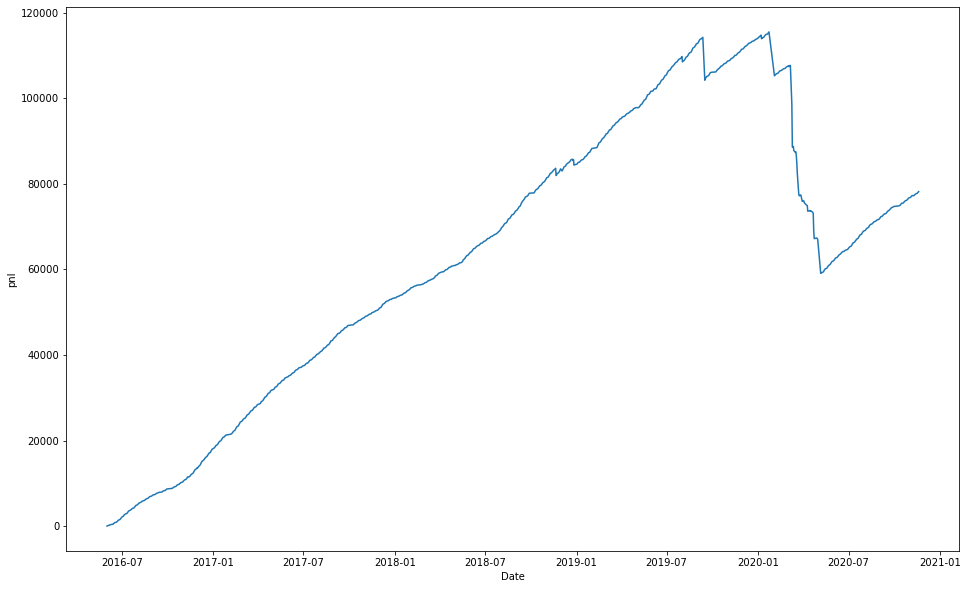

In [53]:
%%time
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_daily_pnl, product='bu', period=1000, tranct_ratio=True, threshold=0.002, tranct=1.1e-4, noise=5)
    result = compute([delayed(f_par)(date) for date in all_dates])[0]

pd.DataFrame(get_performance(result,1), index=[0])

Win Ratio:  1.0
Average PnL:  32.673092351234466
CPU times: user 3.88 s, sys: 359 ms, total: 4.24 s
Wall time: 33.2 s


,sharpe,drawdown,mar,win.ratio,num,avg.pnl,hld.period
0,36.623655,0.0,inf,1.0,7.923713,32.673092,3174.267138


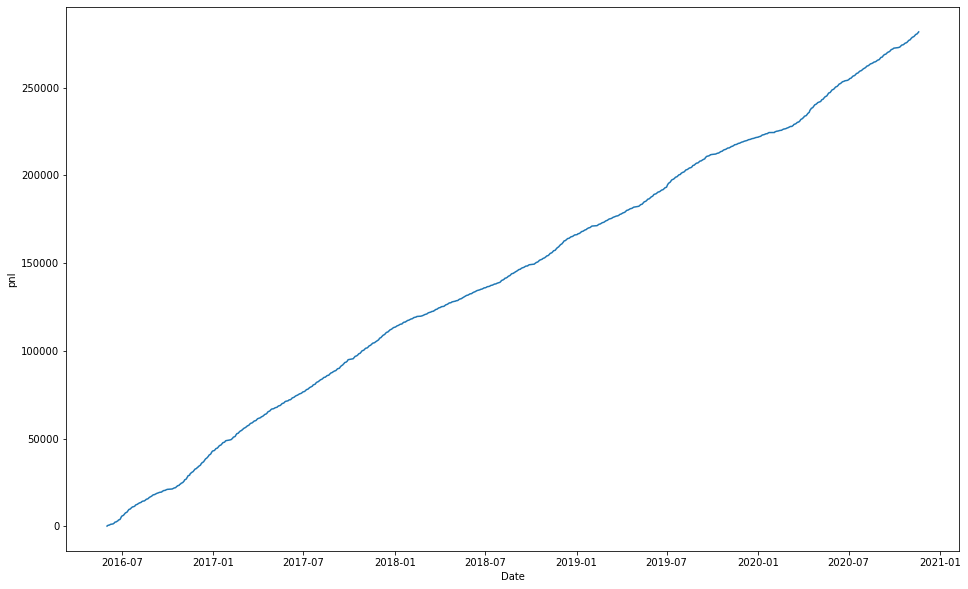

In [52]:
%%time
with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_daily_pnl, product='pp', period=2000, tranct_ratio=True, threshold=0.002, tranct=1.1e-4, noise=0)
    result = compute([delayed(f_par)(date) for date in all_dates])[0]

pd.DataFrame(get_performance(result,1), index=[0])

In [72]:
product = product_list[0]
dire = DATA_PATH + product
print(dire)

/Users/sean/Desktop/Plan B/Quant/energy pkl tick/bu


In [112]:
def get_daily_pnl_fixed_notional(date, product, period, tranct_ratio=False, 
                                 threshold=0.001, tranct=1.1e-4, noise=0, notional=False):
    
    dire = DATA_PATH + product
    with gzip.open(dire + '/' + date, 'rb', compresslevel=1) as file_object:
        raw_data = file_object.read()
    data = cPickle.loads(raw_data)
    data = data[data['good']].reset_index(drop=True)
    
    n_bar = len(data)
    unit = np.std(data['ret'])
    np.random.seed(10)
    noise_ret = np.random.normal(scale=unit*noise, size=n_bar)
    
    ret_period = (data['ret'].rolling(period).sum()).dropna().reset_index(drop=True)
    ret_period = ret_period.append(pd.Series([0] * (len(data) - len(ret_period)))).reset_index(drop=True)
    
    signal = pd.Series([0] * n_bar)
    signal[ret_period > threshold] = 1
    signal[ret_period < -threshold] = -1
    
    position_positive = pd.Series([np.nan] * n_bar)
    position_positive[0] = 0
    position_positive[(signal==1) & (data['next.ask']>0) & (data['next.bid']>0)] = 1
    position_positive[(ret_period < -threshold) & (data['next.bid']>0)] = 0
    position_positive.ffill(inplace=True)
    pre_position_postive = position_positive.shift(1)
    position_positive[(position_positive==1) & (pre_position_postive==1)] = np.nan
    position_positive[(position_positive==1)] = 1/data['next.ask'][(position_positive==1)]
    position_positive.ffill(inplace=True)
    
    position_negative = pd.Series([np.nan] * n_bar)
    position_negative[0] = 0
    position_negative[(signal==-1) & (data['next.ask']>0) & (data['next.bid']>0)] = -1
    position_negative[(ret_period > threshold) & (data['next.ask']>0)] = 0
    position_negative.ffill(inplace=True)
    pre_position_negative = position_negative.shift(1)
    position_negative[(position_negative==-1) & (pre_position_negative==-1)] = np.nan
    position_negative[(position_negative==-1)] = -1/data['next.bid'][(position_negative==-1)]
    position_negative.ffill(inplace=True)
    
    position = position_positive + position_negative
    position[0] = 0
    position[n_bar-1] = 0
    position[n_bar-2] = 0
    
    change_of_position = position - position.shift(1)
    change_of_position[0] = 0
    change_base = pd.Series([0] * n_bar)
    change_buy = change_of_position > 0
    change_sell = change_of_position < 0
    
    if tranct_ratio:
        change_base[change_buy] = data['next.ask'][change_buy] * (1 + tranct)
        change_base[change_sell] = data['next.bid'][change_sell] * (1 - tranct)
    else:
        change_base[change_buy] = data['next.ask'][change_buy] + tranct
        change_base[change_sell] = data['next.bid'][change_sell] - tranct
        
    final_pnl = -sum(change_base * change_of_position)
    turnover = sum(change_base * abs(change_of_position))
    num = sum((position != 0) & (change_of_position != 0))
    hld_period = sum(position != 0)
    
    result = OrderedDict([("date", date), ("final.pnl", final_pnl), ("turnover", turnover),
                          ("num", num), ("hld.period", hld_period)])
    return result

In [113]:
get_daily_pnl_fixed_notional(all_dates[0], product="bu", period=4096, tranct_ratio=True, 
                             threshold=0.001, tranct=1.1e-4, noise=0, notional=True)

OrderedDict([('date', '20160601.pkl'),
             ('final.pnl', 0.01273032716592326),
             ('turnover', 31.999077529253746),
             ('num', 16),
             ('hld.period', 39518)])

Win Ratio:  0.9898897058823529
Average PnL:  0.0019119587926491133
CPU times: user 3min 25s, sys: 1min 17s, total: 4min 43s
Wall time: 2min 54s


,sharpe,drawdown,mar,win.ratio,num,avg.pnl,hld.period
0,25.888223,0.000232,4308.186019,0.98989,13.943934,0.001912,2586.021027


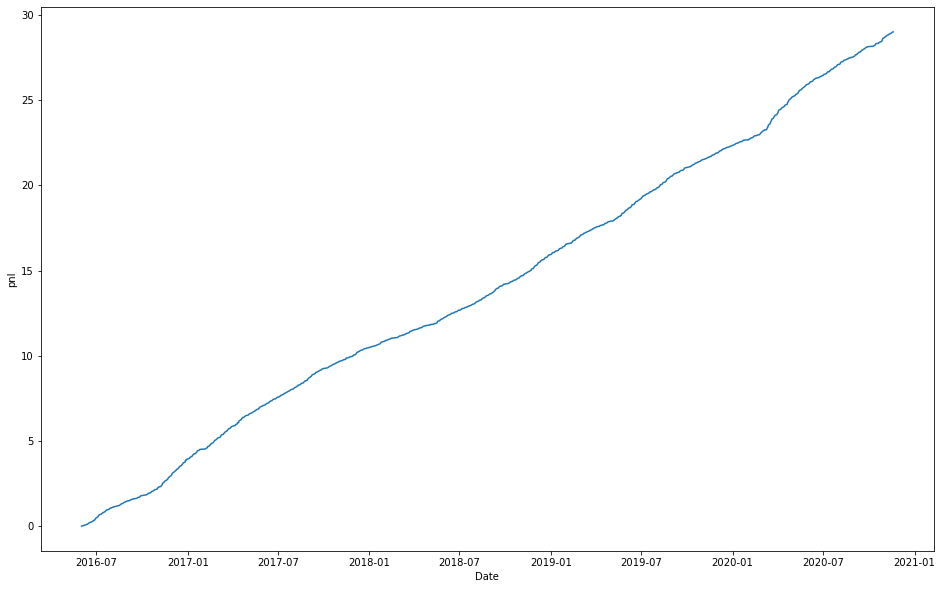

In [114]:
%%time
with dask.config.set(schedual='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_daily_pnl_fixed_notional, product='bu', period=4096, tranct_ratio=True,
                              threshold=0.001, tranct=1.1e-4, noise=0, notional=True)
    result = compute([delayed(f_par)(date) for date in all_dates])[0]
    
pd.DataFrame(get_performance(result, 1), index=[0])

Win Ratio:  0.9917279411764706
Average PnL:  0.0025167268281137533
CPU times: user 2min 46s, sys: 59.3 s, total: 3min 45s
Wall time: 2min 17s


,sharpe,drawdown,mar,win.ratio,num,avg.pnl,hld.period
0,25.087289,0.000186,5388.73364,0.991728,7.522059,0.002517,2284.852395


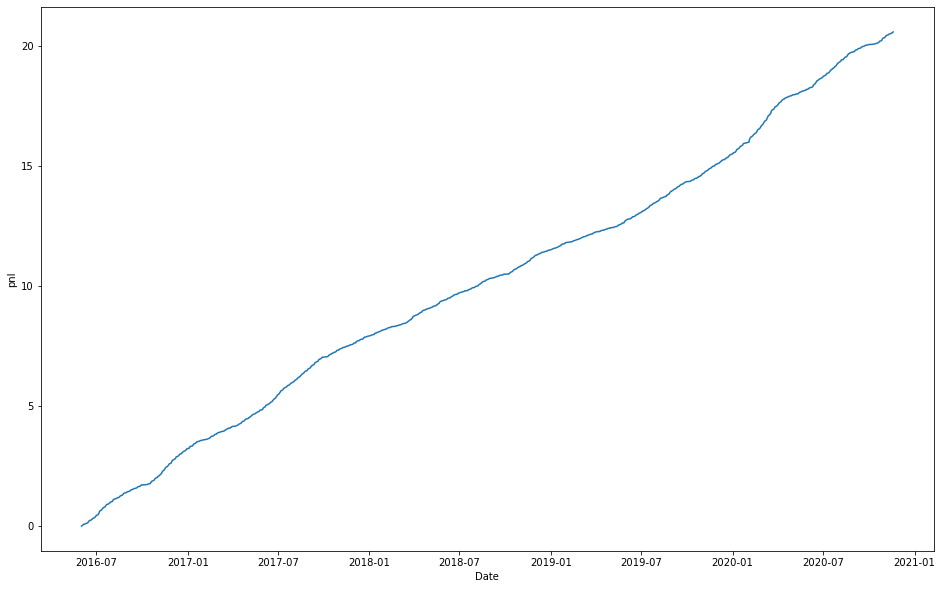

In [115]:
%%time
with dask.config.set(schedual='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_daily_pnl_fixed_notional, product='jd', period=4096, tranct_ratio=False,
                              threshold=0.001, tranct=1.1e-4, noise=0, notional=True)
    result = compute([delayed(f_par)(date) for date in all_dates])[0]
    
pd.DataFrame(get_performance(result, 1), index=[0])

Win Ratio:  0.9862132352941176
Average PnL:  0.001896264905449105
CPU times: user 2min 11s, sys: 46.1 s, total: 2min 57s
Wall time: 1min 50s


,sharpe,drawdown,mar,win.ratio,num,avg.pnl,hld.period
0,22.751219,0.000407,2455.822661,0.986213,9.460478,0.001896,1708.772564


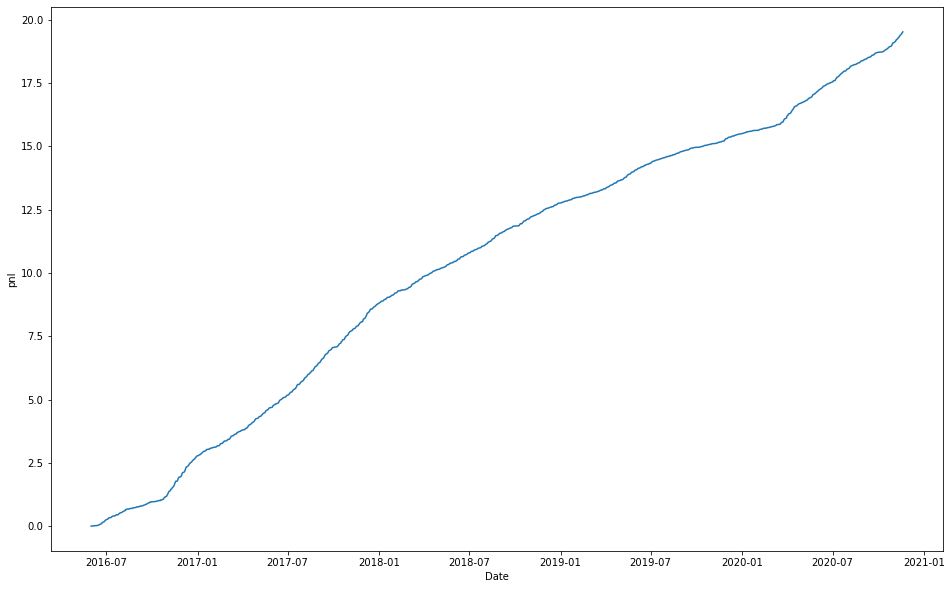

In [116]:
%%time
with dask.config.set(schedual='processes', num_workers=CORE_NUM):
    f_par = functools.partial(get_daily_pnl_fixed_notional, product='v', period=2048, tranct_ratio=True,
                              threshold=0.001, tranct=1.1e-4, noise=0, notional=True)
    result = compute([delayed(f_par)(date) for date in all_dates])[0]
    
pd.DataFrame(get_performance(result, 1), index=[0])